## Exploration

train.csv shape is  (139753, 9)
test.csv shape is  (17470, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   195370  1890228583  A3VLX5Z090RQ0V                     1   
1  1632470  B00BEIYSL4   AUDXDMFM49NGY                     0   
2     9771  0767809335  A3LFIA97BUU5IE                     3   
3   218855  6300215792  A1QZM75342ZQVQ                     1   
4   936225  B000B5XOZW   ANM2SCEUL3WL1                     1   

   HelpfulnessDenominator        Time  \
0                       2  1030838400   
1                       1  1405036800   
2                      36   983750400   
3                       1  1394841600   
4                       1  1163721600   

                                             Summary  \
0                        An Unexplained Anime Review   
1                                         not great.   
2                    Technical problem with this DVD   
3                          Heeeeyyyyy LAAAAADEEE!!!!   
4  Herzog the Great Trave

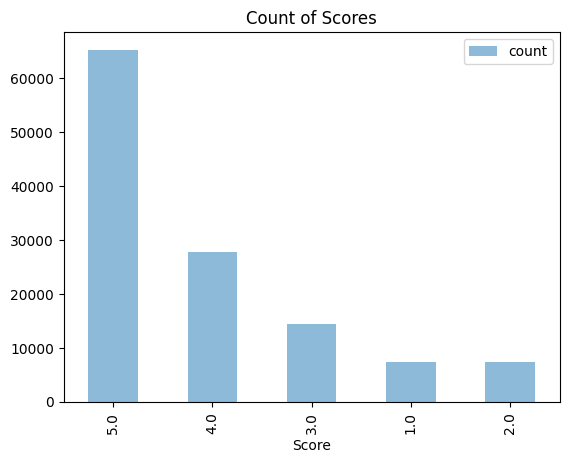

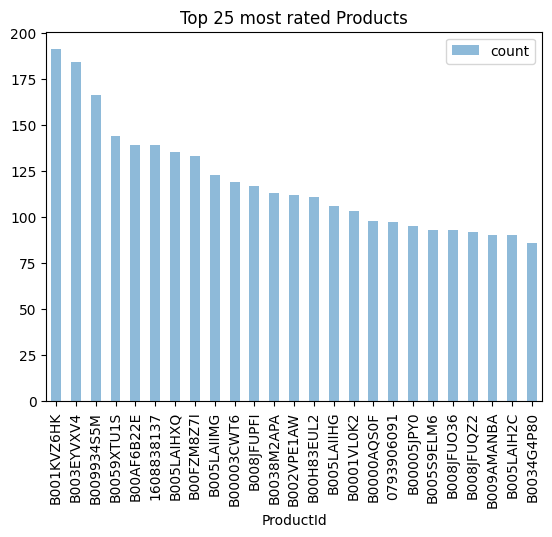

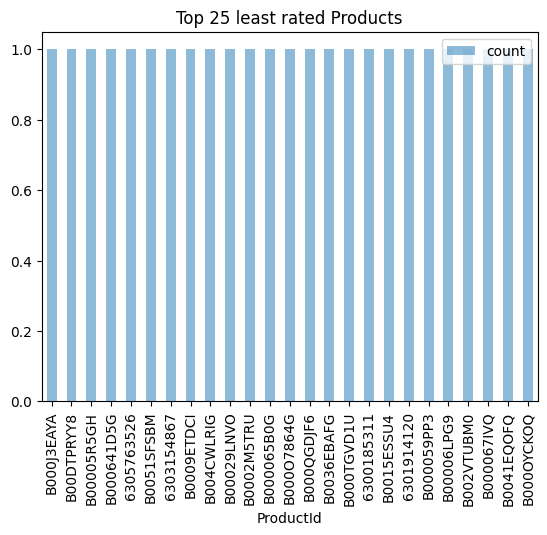

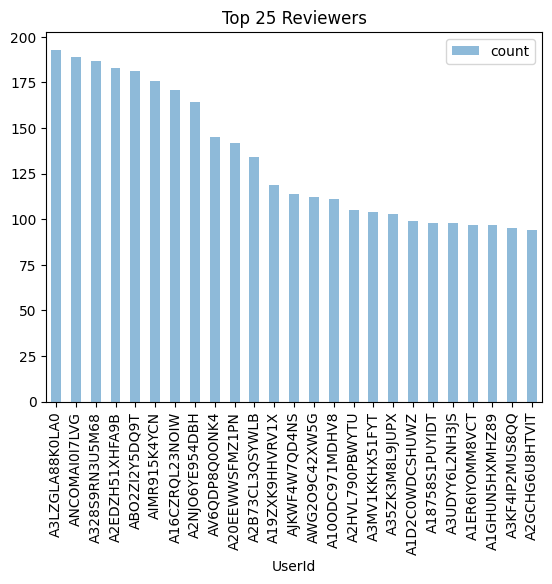

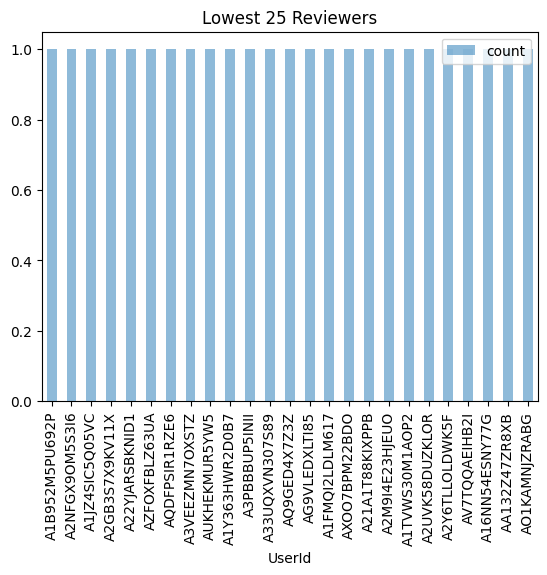

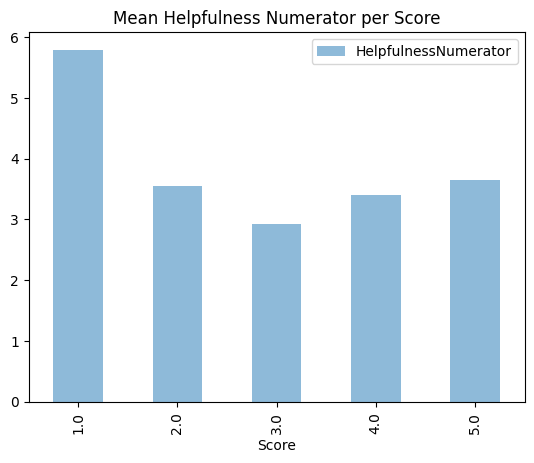

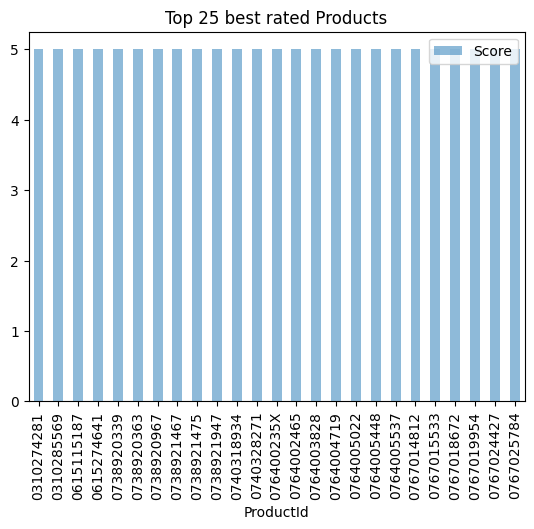

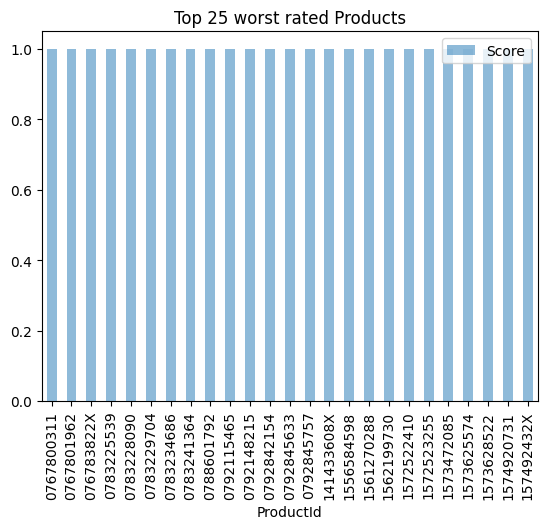

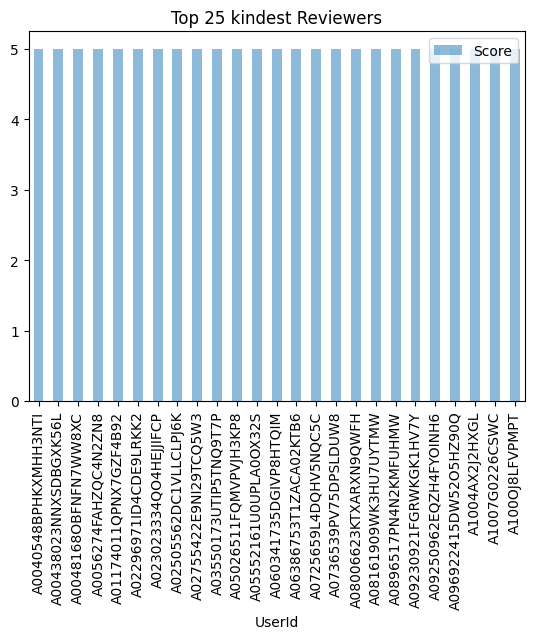

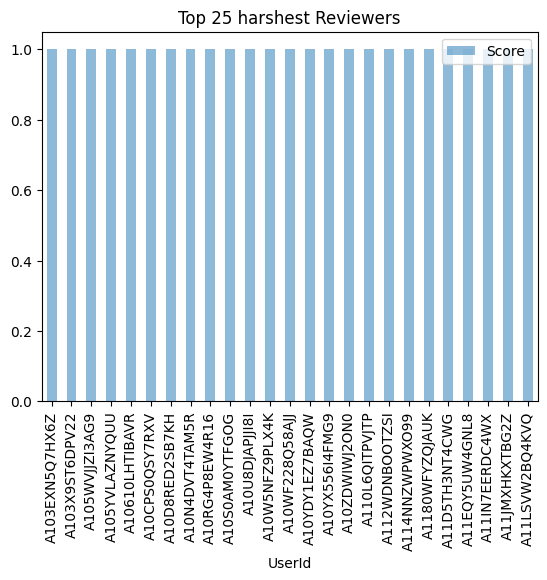

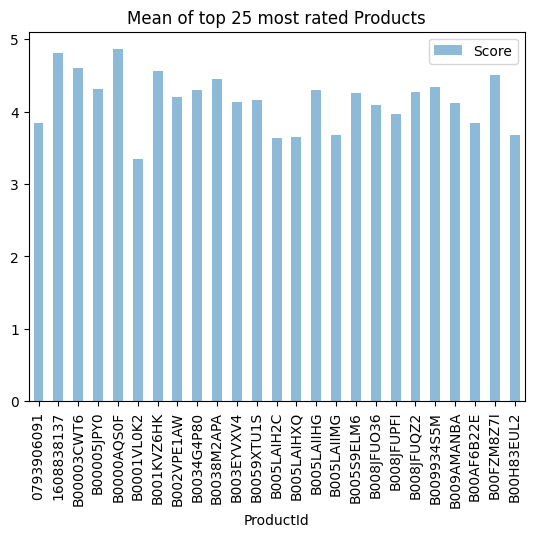

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Count of Scores")
plt.show()

trainingSet['ProductId'].value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 most rated Products")
plt.show()

trainingSet['ProductId'].value_counts().nsmallest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 least rated Products")
plt.show()

trainingSet['UserId'].value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 Reviewers")
plt.show()

trainingSet['UserId'].value_counts().nsmallest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Lowest 25 Reviewers")
plt.show()

trainingSet[['Score', 'HelpfulnessNumerator']].groupby('Score').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Mean Helpfulness Numerator per Score")
plt.show()

trainingSet[['Score', 'ProductId']].groupby('ProductId').mean().nlargest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 best rated Products")
plt.show()

trainingSet[['Score', 'ProductId']].groupby('ProductId').mean().nsmallest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 worst rated Products")
plt.show()

trainingSet[['Score', 'UserId']].groupby('UserId').mean().nlargest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 kindest Reviewers")
plt.show()

trainingSet[['Score', 'UserId']].groupby('UserId').mean().nsmallest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 harshest Reviewers")
plt.show()

trainingSet[trainingSet['ProductId'].isin(trainingSet['ProductId'].value_counts().nlargest(25).index.tolist())][['Score', 'ProductId']].groupby('ProductId').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Mean of top 25 most rated Products")
plt.show()

## Feature Extraction

In [16]:
import pandas as pd
from textblob import TextBlob

def get_sentiment(text):
    # Check if text is a string
    if isinstance(text, str):
        # Create TextBlob object
        blob = TextBlob(text)
        # Get polarity
        polarity = blob.sentiment.polarity
        # Adjust polarity to range from 0 to 2
        adjusted_polarity = polarity + 1
        # Scale adjusted polarity to range from 0 to 4
        scaled_polarity = adjusted_polarity * 2
        # Shift scaled polarity to range from 1 to 5
        final_polarity = scaled_polarity + 1
        # Return final polarity
        return final_polarity
    else:
        # Return neutral sentiment for non-string input
        return 3

def process(df):
    # This is where you can do all your processing
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    # extract review and title sentiment
    df['Review_Sentiment'] = df['Text'].apply(get_sentiment)
    df['Title_Sentiment'] = df['Summary'].apply(get_sentiment)
    
    # Calculate number of exclamation marks
    df['ExclamationMarks'] = df['Text'].apply(lambda x: x.count('!') if pd.notnull(x) else 0)
    
    # Calculate use of capital letters
    df['CapitalLetters'] = df['Text'].apply(lambda x: sum(1 for c in x if c.isupper()) if pd.notnull(x) else 0)
    
    # Add length of the review as a feature
    df['Review_Length'] = df['Text'].apply(lambda x: len(x) if pd.notnull(x) else 0)

    # Add count of positive and negative words as features
    positive_words = ['good', 'great', 'excellent', 'amazing', 'positive', 'recommend', 'love']
    negative_words = ['bad', 'terrible', 'awful', 'worst', 'negative', 'not recommend', 'hate']

    df['Positive_Words'] = df['Text'].apply(lambda x: sum(word in x for word in positive_words) if pd.notnull(x) else 0)
    df['Negative_Words'] = df['Text'].apply(lambda x: sum(word in x for word in negative_words) if pd.notnull(x) else 0)

    return df

# Load the dataset
trainingSet = pd.read_csv("./data/train.csv")

# Process the DataFrame
train_processed = process(trainingSet)

# Load test set
submissionSet = pd.read_csv("./data/test.csv")

# Merge on Id so that the test set can have feature columns as well
testX= pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
testX = testX.drop(columns=['Score_x'])
testX = testX.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
trainX = train_processed[train_processed['Score'].notnull()]

# Save the datasets with the new features for easy access later
testX.to_csv("./data/X_test.csv", index=False)
trainX.to_csv("./data/X_train.csv", index=False)


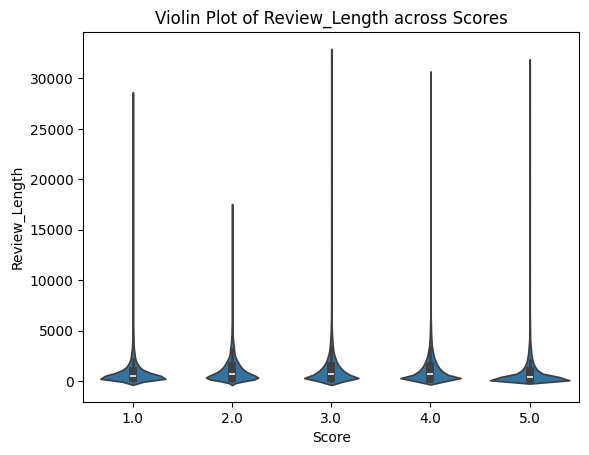

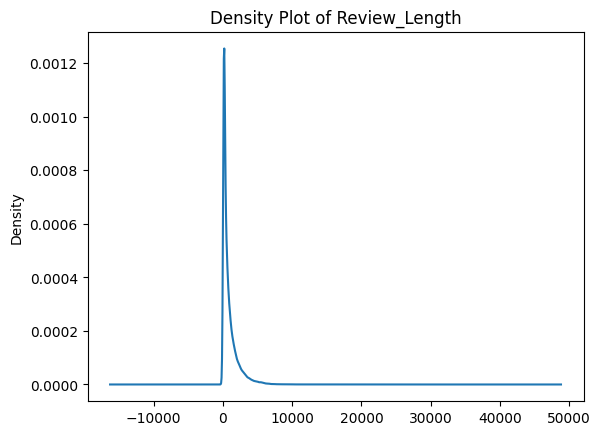

In [23]:
import seaborn as sns

sns.violinplot(x='Score', y='Review_Length', data=train_processed)
plt.title("Violin Plot of Review_Length across Scores")
plt.show()

Accuracy on testing set =  0.46478688953583464
RMSE on testing set =  0.9555219229145187


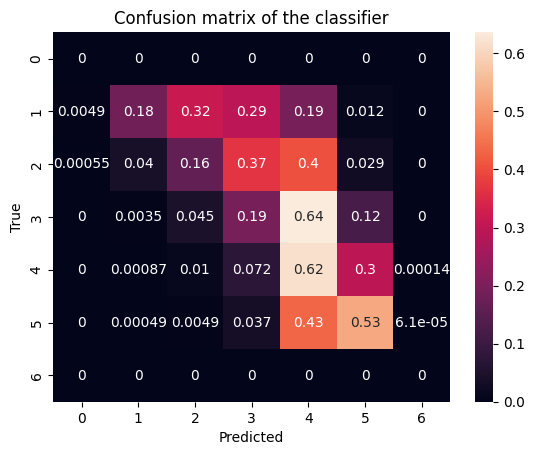

In [24]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from sklearn.model_selection import GridSearchCV

# Load training set with new features into DataFrame
X_train = pd.read_csv("./data/X_train.csv")

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['Score'], axis=1),
        X_train['Score'],
        test_size=1/4.0,
        random_state=0
    )   

# 'Id','ProductId','UserId','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary','Text','Score','Helpfulness','ReviewLength','UserAvgScore','MovieAvgScore'
# X_train_processed = X_train.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary'])
# X_test_processed = X_test.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary'])
# This is where you can do more feature selection
X_train_processed = X_train.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Time'])
X_test_processed = X_test.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Time'])

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [1, 2, 3],
#     'loss': ['squared_error']
# }

# # Create a GradientBoostingRegressor
# model = GradientBoostingRegressor(random_state=0)

# # Create a GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# # Fit the GridSearchCV
# grid_search.fit(X_train_processed, Y_train)

# # Get the best parameters
# best_params = grid_search.best_params_

# # Print the best parameters
# print("Best parameters: ", best_params)

# # Create a GradientBoostingRegressor with the best parameters
# model = GradientBoostingRegressor(**best_params, random_state=0)

# param_grid = {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'n_estimators': 300}
model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=0, loss='squared_error')
# Fit the model
model.fit(X_train_processed, Y_train)

# Make predictions
Y_test_predictions = model.predict(X_test_processed)

# Since GradientBoostingRegressor gives continuous output, we round off the prediction to nearest integer
Y_test_predictions = np.round(Y_test_predictions)

# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions)**(1/2))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

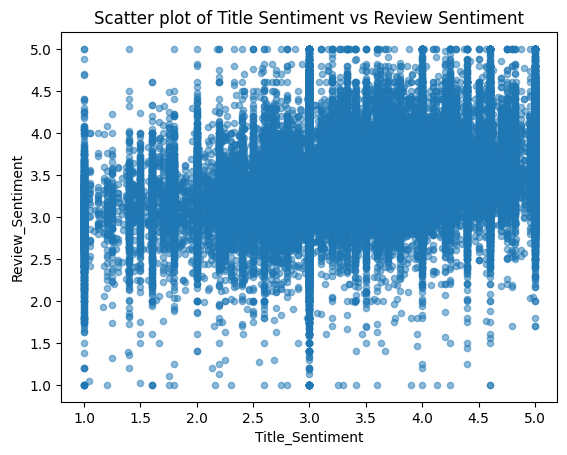

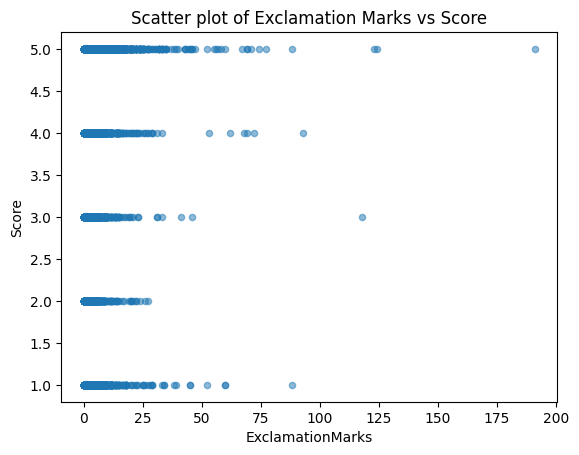

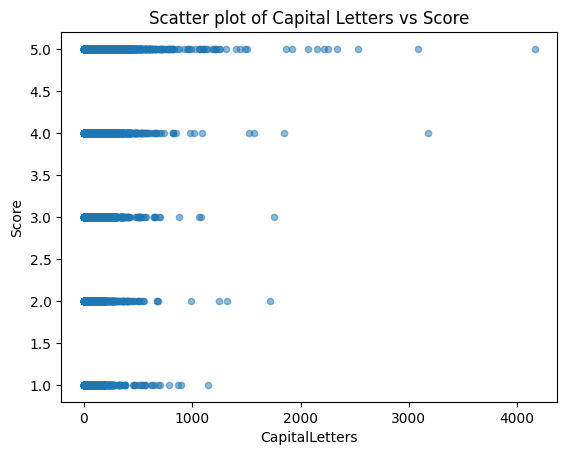

In [27]:

# Scatter plot for Title_Sentiment and Review_Sentiment
train_processed[['Title_Sentiment', 'Review_Sentiment']].plot(kind='scatter', x='Title_Sentiment', y='Review_Sentiment', alpha=0.5)
plt.title("Scatter plot of Title Sentiment vs Review Sentiment")
plt.show()

# Scatter plot for ExclamationMarks and Score
train_processed.plot(kind='scatter', x='ExclamationMarks', y='Score', alpha=0.5)
plt.title("Scatter plot of Exclamation Marks vs Score")
plt.show()

# Scatter plot for CapitalLetters and Score
train_processed.plot(kind='scatter', x='CapitalLetters', y='Score', alpha=0.5)
plt.title("Scatter plot of Capital Letters vs Score")
plt.show()



## Create the Kaggle submission

In [25]:
X_submission = pd.read_csv("./data/X_test.csv")
X_submission_processed = X_submission.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Score', 'Time'])
print(X_submission_processed.columns)
X_submission['Score'] = model.predict(X_submission_processed)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

Index(['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness',
       'Review_Sentiment', 'Title_Sentiment', 'ExclamationMarks',
       'CapitalLetters', 'Review_Length', 'Positive_Words', 'Negative_Words'],
      dtype='object')


Now you can upload the `submission.csv` to kaggle